=== Cs Rydberg THz quick check ===
Transition: Cs 14P_3/2  ↔  13D_5/2
f = 5.485e+11 Hz  (~0.548 THz)
Lifetimes: tau_14P ≈ 3.834e-06 s,  tau_13D ≈ 8.231e-07 s
|μ| (C·m) for mJ 0.5->0.5, q=0: 0.000e+00

Power->Field->Rabi (per 40×40 µm² pixel)
         P (W)        E (V/m)      Ω/2π (Hz)
     2.000e-13      3.069e-01      0.000e+00
     1.000e-12      6.862e-01      0.000e+00
     5.000e-12      1.534e+00      0.000e+00
     2.000e-11      3.069e+00      0.000e+00
     5.000e-11      4.852e+00      0.000e+00

At ~20.0 pW/pixel: E ≈ 3.07 V/m,  Ω/2π ≈ 0 Hz

[StarkMap] building basis and diagonalising ... (this may take a few seconds)


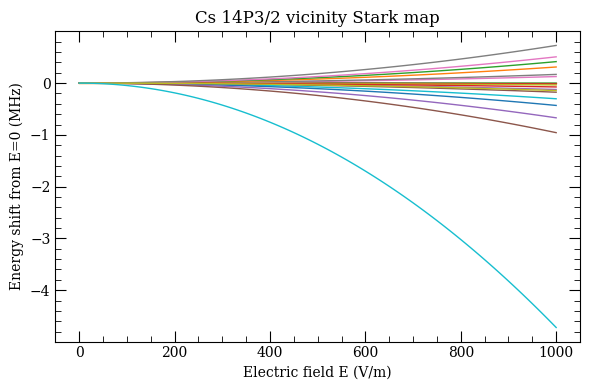


Notes:
- The plotted curves show energy shifts vs DC field near the 14P3/2 manifold.
- You can increase (nMin,nMax,lMax) for a denser basis (more accurate, slower).
- For different polarization (σ±), change the 'q' in getDipoleMatrixElement(q=±1).
- If you want BBR-included lifetimes, set temperature_K = 300.0 (if supported in your ARC version).
- The Ω values help judge linear vs saturation regime vs total decoherence/linewidth (~14 MHz reported).


In [3]:
# =======================
# Cs Rydberg THz Imaging (PRX 2020) quick analysis with ARC 3.x
# - Transition: 14P3/2 <-> 13D5/2  (~0.55 THz)
# - Computes: transition freq, lifetimes, dipole element, saturation check,
#             simple power->field->Rabi mapping, Stark map scan + plot
# =======================

# 0) Install ARC if missing (safe to run multiple times)
try:
    from arc import Caesium, StarkMap
except Exception as e:
    import sys, subprocess
    print("[info] ARC not found or import failed, installing from GitHub...")
    subprocess.check_call([sys.executable, "-m", "pip", "install",
                           "git+https://github.com/nikolasibalic/ARC-Alkali-Rydberg-Calculator.git"])
    from arc import Caesium, StarkMap

import numpy as np
import math
import matplotlib.pyplot as plt

# ---------- Constants ----------
hbar = 1.054_571_817e-34
c    = 299_792_458.0
eps0 = 8.854_187_8128e-12

# ---------- User-configurable block ----------
# Target Rydberg states (Cs): 14P3/2 and 13D5/2
nP,lP,jP,mjP = 14, 1, 1.5, 0.5
nD,lD,jD,mjD = 13, 2, 2.5, 0.5

# Pixel size and power for linear-to-saturation check (from PRX paper)
pixel_side_um = 40.0               # (40 x 40) um^2
P_lin_top     = 20e-12             # ~20 pW/pixel linear upper bound (reported)
P_demo_list   = [0.2e-12, 1e-12, 5e-12, 20e-12, 50e-12]  # demo powers

# Stark map scan range [V/m]
Emin, Emax, nE = 0.0, 1.0e3, 101   # 0 ~ 1000 V/m
# Basis around the target state
nMin, nMax, lMax = 10, 18, 5       # keep modest for speed in notebook

# Temperature for lifetimes (0 K default; set e.g. 300 for BBR-included lifetimes if available in your ARC version)
temperature_K = None  # None or a float like 300.0

# ---------- Helper functions ----------
def E_from_power_per_pixel(P_watt, pixel_side_um):
    """Compute rms E-field (V/m) for a plane wave given power incident on a square pixel."""
    A = (pixel_side_um*1e-6)**2
    I = P_watt / A
    # For a plane wave: I = (1/2) * c * eps0 * E^2  =>  E = sqrt(2I/(c eps0))
    return math.sqrt(2.0*I/(c*eps0))

def hz_to_thz(f_hz): return f_hz/1e12

# ---------- ARC computations ----------
cs = Caesium()

# (1) Transition frequency (Hz) for 14P3/2 <-> 13D5/2
try:
    f_hz = cs.getTransitionFrequency(nP,lP,jP, nD,lD,jD)
except Exception:
    # Some ARC versions expect absolute energies subtracted; fallback:
    E_14P = cs.getEnergy(nP,lP,jP)  # [Hz]
    E_13D = cs.getEnergy(nD,lD,jD)  # [Hz]
    f_hz  = abs(E_14P - E_13D)

# (2) Lifetimes (s)
def lifetime(n,l,j):
    if temperature_K is None:
        return cs.getStateLifetime(n,l,j)
    else:
        # Some ARC versions support temperature argument; try gracefully
        try:
            return cs.getStateLifetime(n,l,j, temperature=temperature_K)
        except TypeError:
            return cs.getStateLifetime(n,l,j)

tau_14P = lifetime(nP,lP,jP)
tau_13D = lifetime(nD,lD,jD)

# (3) Dipole matrix element (C·m) reduced element via specific mJ coupling
# For linear (π) THz polarization, q=0 (Δm=0) term dominates; s=0: spin
mu = cs.getDipoleMatrixElement(nD,lD,jD,mjD, nP,lP,jP,mjP, q=0, s=0)

# (4) Power -> E-field -> Rabi frequency
def rabi_from_power(P):
    E = E_from_power_per_pixel(P, pixel_side_um)
    Omega = abs(mu)*E/hbar                           # [rad/s]
    return E, Omega, Omega/(2*math.pi)              # E [V/m], Ω, Ω/2π [Hz]

# (5) Print quick summary
print("=== Cs Rydberg THz quick check ===")
print(f"Transition: Cs {nP}P_{int(2*jP)}/{2}  ↔  {nD}D_{int(2*jD)}/{2}")
print(f"f = {f_hz:.3e} Hz  (~{hz_to_thz(f_hz):.3f} THz)")
print(f"Lifetimes: tau_14P ≈ {tau_14P:.3e} s,  tau_13D ≈ {tau_13D:.3e} s")
print(f"|μ| (C·m) for mJ {mjP}->{mjD}, q=0: {abs(mu):.3e}")

# (6) Demo table: power -> E, Ω/2π
rows = []
for P in P_demo_list:
    E, Om, OmHz = rabi_from_power(P)
    rows.append((P, E, OmHz))
colw = [14, 14, 14]
print("\nPower->Field->Rabi (per 40×40 µm² pixel)")
print("{:>14s} {:>14s} {:>14s}".format("P (W)", "E (V/m)", "Ω/2π (Hz)"))
for P,E,OmHz in rows:
    print("{:14.3e} {:14.3e} {:14.3e}".format(P,E,OmHz))

# (7) Check near-linear top power (~20 pW)
E_lin, Om_lin, OmHz_lin = rabi_from_power(P_lin_top)
print(f"\nAt ~{P_lin_top*1e12:.1f} pW/pixel: E ≈ {E_lin:.3g} V/m,  Ω/2π ≈ {OmHz_lin:.3g} Hz")

# ---------- Stark map ----------
print("\n[StarkMap] building basis and diagonalising ... (this may take a few seconds)")
sm = StarkMap(cs)
# defineBasis(target_n, target_l, target_j, target_mj, nMin, nMax, maxL, [debugOutput=False, progressOutput=False])
sm.defineBasis(nP, lP, jP, mjP, nMin, nMax, lMax)

E_list = np.linspace(Emin, Emax, nE)  # V/m
# diagonalise electric-field list
sm.diagonalise(E_list)

# Retrieve eigen-energies (in Hz) vs field; ARC stores internally; use provided getters
# We'll pick a subset of levels near the target; ARC's StarkMap typically exposes .energies list of arrays
energies = np.array(sm.y)           # 에너지 고유값 배열
fields   = np.array(sm.eFieldList)  # 전기장(V/m) 리스트

# E=0에서 상대 이동량으로 보기 (단위: ARC 내부는 GHz; 아래는 MHz로 표시)
E0 = energies[0, :].copy()
energies_centered = (energies - E0) * 1e3  # GHz -> MHz

import matplotlib.pyplot as plt
plt.figure(figsize=(6,4))
nLevelsToPlot = min(20, energies_centered.shape[1])
for idx in range(nLevelsToPlot):
    plt.plot(fields, energies_centered[:, idx], lw=1)
plt.xlabel("Electric field E (V/m)")
plt.ylabel("Energy shift from E=0 (MHz)")
plt.title("Cs 14P3/2 vicinity Stark map")
plt.tight_layout()
plt.show()

# ---------- Notes ----------
print("\nNotes:")
print("- The plotted curves show energy shifts vs DC field near the 14P3/2 manifold.")
print("- You can increase (nMin,nMax,lMax) for a denser basis (more accurate, slower).")
print("- For different polarization (σ±), change the 'q' in getDipoleMatrixElement(q=±1).")
print("- If you want BBR-included lifetimes, set temperature_K = 300.0 (if supported in your ARC version).")
print("- The Ω values help judge linear vs saturation regime vs total decoherence/linewidth (~14 MHz reported).")